In [1]:
import numpy as np
import pandas as pd 

In [2]:
data = pd.read_csv('data/mnist_with_anomalies.csv')
data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
matrix = data.to_numpy()
matrix.shape

(6963, 784)

In [4]:
matrix


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [5]:
first = matrix[3093]
first = first.reshape(28,28)

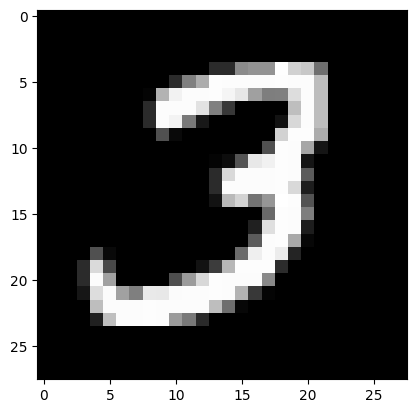

In [6]:
import matplotlib.pyplot as plt

plt.imshow(first, cmap='gray')

In [223]:
anomalies_indices = np.array([81, 143, 223, 329, 352, 401, 663, 701, 712, 790, 863, 2597, 2609, 2658, 2704, 2726, 2781, 3093, 3203, 3295, 6065, 6229, 6235, 6535, 6857])
anomalies_matrix = matrix[anomalies_indices]
def percentage_of_finded_anomalities(found_anomalities, total_anomalities):
    num_of_anomalities = len(total_anomalities)
    count = 0
    for index in found_anomalities:
        if index in total_anomalities:
            count += 1
    return count / num_of_anomalities * 100

percentage_of_finded_anomalities(anomalies_indices, anomalies_indices)

100.0

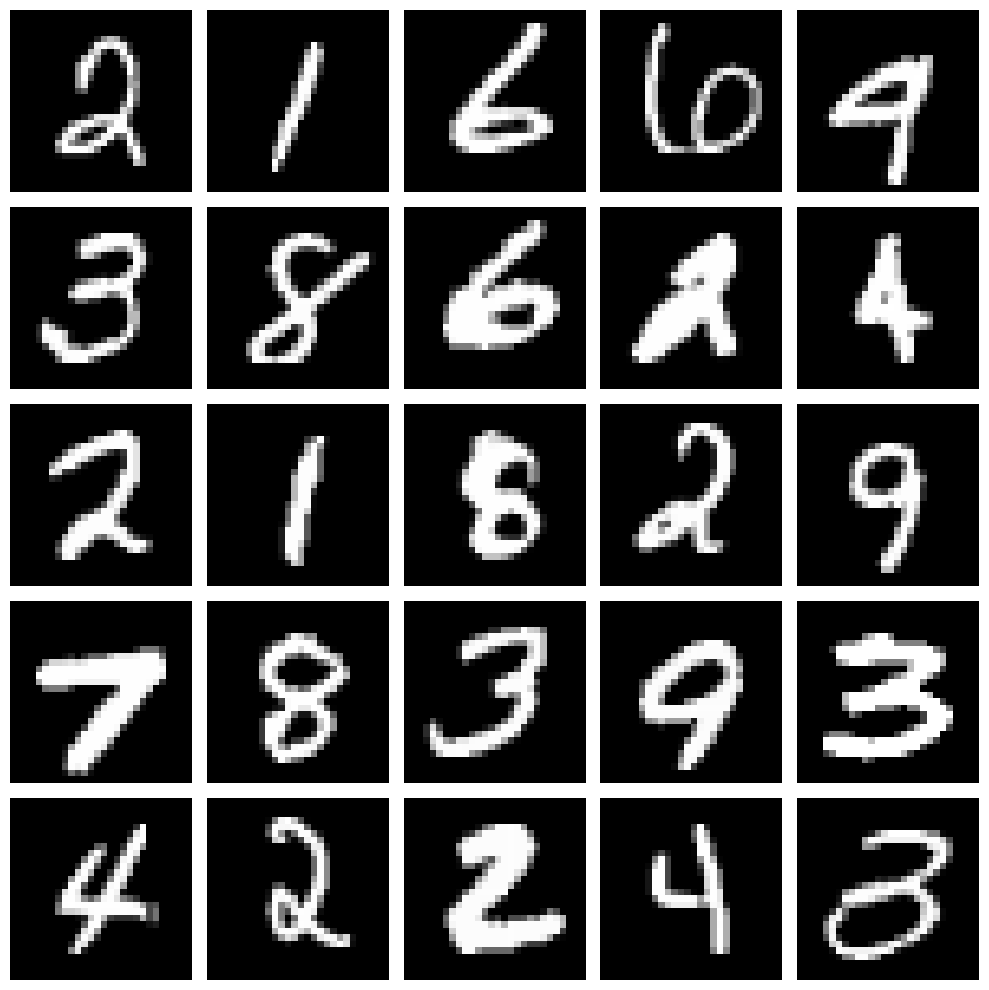

In [8]:
cols = 5
rows = int(np.ceil(len(anomalies_indices) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < len(anomalies_indices):
        axes[i].imshow(anomalies_matrix[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [9]:
from sklearn.decomposition import PCA


pca = PCA(n_components=0.95)

In [ ]:
matrix_pca = pca.fit_transform(matrix)



In [11]:
matrix_reconstructed = pca.inverse_transform(matrix_pca)

In [12]:
reconstruction_error = np.mean((matrix - matrix_reconstructed) ** 2, axis=1)

In [ ]:
threshold = np.percentile(reconstruction_error, 99.5)

In [14]:
anomalies = np.where(reconstruction_error > threshold)[0]

In [15]:
print("Anomalies detected at indices:", anomalies)


Anomalies detected at indices: [ 223  322  329  352  663  785  945 1328 1369 1378 1421 1501 1506 1721
 1759 2726 3110 3295 3353 3377 3602 3622 3783 3850 4006 4134 4195 4237
 4327 4445 4949 5151 5216 5985 6229]


In [270]:
components_range = range(80, 100)
for i in components_range:
    pca = PCA(n_components=i/100)
    matrix_pca = pca.fit_transform(matrix)
    matrix_reconstructed = pca.inverse_transform(matrix_pca)
    reconstruction_error = np.mean((matrix - matrix_reconstructed) ** 2, axis=1)
    threshold = np.percentile(reconstruction_error, 98)
    anomalies = np.where(reconstruction_error > threshold)[0]
    score = percentage_of_finded_anomalities(anomalies, anomalies_indices)
    print(f"for component:{i/100}, score: {score}")
    

for component:0.8, score: 84.0
for component:0.81, score: 88.0
for component:0.82, score: 88.0
for component:0.83, score: 92.0
for component:0.84, score: 92.0
for component:0.85, score: 88.0
for component:0.86, score: 88.0
for component:0.87, score: 84.0
for component:0.88, score: 84.0
for component:0.89, score: 84.0
for component:0.9, score: 84.0
for component:0.91, score: 80.0
for component:0.92, score: 80.0
for component:0.93, score: 76.0
for component:0.94, score: 72.0
for component:0.95, score: 68.0
for component:0.96, score: 60.0
for component:0.97, score: 52.0
for component:0.98, score: 36.0
for component:0.99, score: 32.0


In [283]:
pca = PCA(n_components=0.83)
matrix_pca = pca.fit_transform(matrix)
matrix_reconstructed = pca.inverse_transform(matrix_pca)
reconstruction_error = np.mean((matrix - matrix_reconstructed) ** 2, axis=1)
for percent in range(999, 950, -1):
    percent = percent / 10
    threshold = np.percentile(reconstruction_error, percent)
    anomalies = np.where(reconstruction_error > threshold)[0]
    score = percentage_of_finded_anomalities(anomalies, anomalies_indices)
    print(f"for percent:{percent}, score: {score}")
    if score == 100:
        break



for percent:99.9, score: 12.0
for percent:99.8, score: 20.0
for percent:99.7, score: 24.0
for percent:99.6, score: 36.0
for percent:99.5, score: 40.0
for percent:99.4, score: 44.0
for percent:99.3, score: 48.0
for percent:99.2, score: 52.0
for percent:99.1, score: 60.0
for percent:99.0, score: 60.0
for percent:98.9, score: 68.0
for percent:98.8, score: 68.0
for percent:98.7, score: 76.0
for percent:98.6, score: 80.0
for percent:98.5, score: 80.0
for percent:98.4, score: 84.0
for percent:98.3, score: 84.0
for percent:98.2, score: 88.0
for percent:98.1, score: 88.0
for percent:98.0, score: 92.0
for percent:97.9, score: 92.0
for percent:97.8, score: 92.0
for percent:97.7, score: 96.0
for percent:97.6, score: 96.0
for percent:97.5, score: 96.0
for percent:97.4, score: 96.0
for percent:97.3, score: 96.0
for percent:97.2, score: 96.0
for percent:97.1, score: 100.0


202
97.1


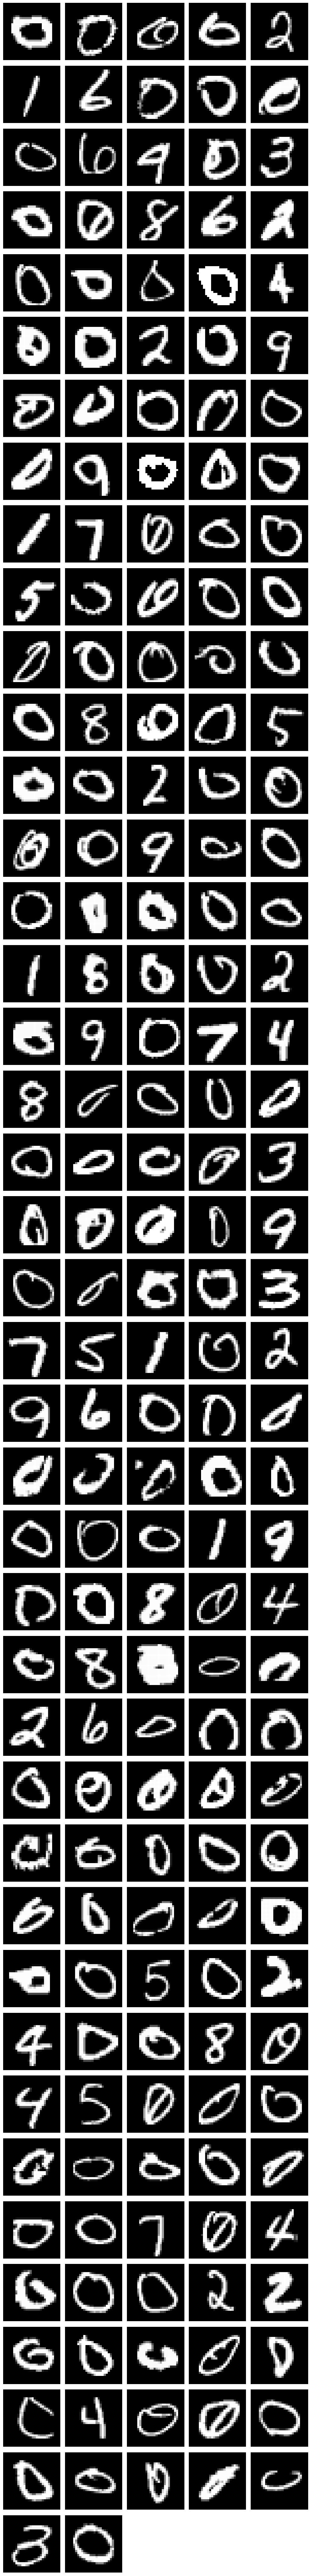

In [284]:
pca_anomaly_matrix = matrix[anomalies].reshape(-1, 28, 28)
num_anomalies = len(pca_anomaly_matrix)
print(num_anomalies)
print(percent)
cols = 5
rows = int(np.ceil(num_anomalies / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < num_anomalies:
        axes[i].imshow(pca_anomaly_matrix[i], cmap='gray')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [282]:
percentage_of_finded_anomalities(anomalies, anomalies_indices)

0.0

GMM

BIC score

In [47]:
from sklearn.mixture import GaussianMixture
n_components_range = range(1,11)
bic_scores = []
aic_scores = []


for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=500, init_params='kmeans', random_state=42, tol=1e-6)
    gmm.fit(matrix)
    aic_scores.append(gmm.aic(matrix))
    bic_scores.append(gmm.bic(matrix))

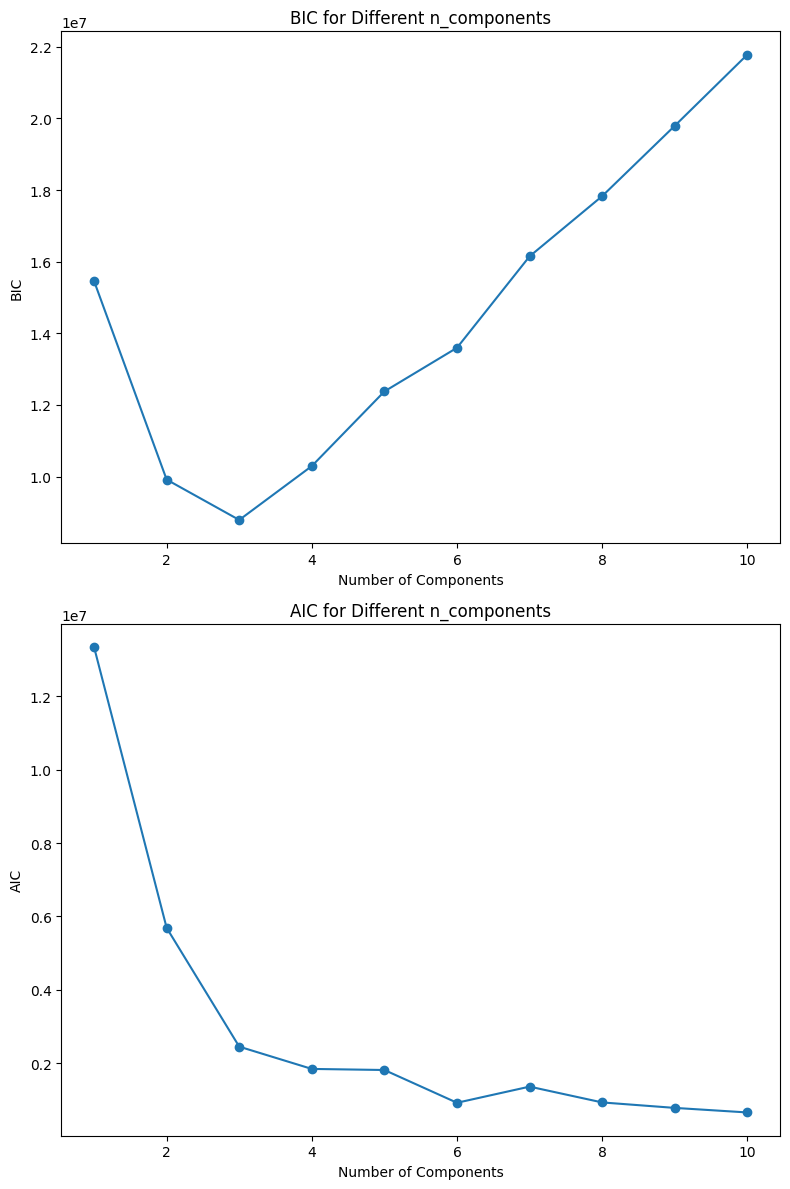

Best n_components based on BIC: 3
Best n_components based on AIC: 10


In [48]:
figure, axis = plt.subplots(2, 1, figsize = (8, 12))

axis[0].plot(n_components_range, bic_scores, marker = "o")
axis[0].set_title("BIC for Different n_components")
axis[0].set_xlabel("Number of Components")
axis[0].set_ylabel("BIC")

axis[1].plot(n_components_range, aic_scores , marker = "o")
axis[1].set_title("AIC for Different n_components")
axis[1].set_xlabel("Number of Components")
axis[1].set_ylabel("AIC")

plt.tight_layout()
plt.show()

best_n_components = n_components_range[np.argmin(bic_scores)]
print(f"Best n_components based on BIC: {best_n_components}")

best_n_components = n_components_range[np.argmin(aic_scores)]
print(f"Best n_components based on AIC: {best_n_components}")


AIC

In [208]:
gmm = GaussianMixture(n_components=4, covariance_type='full', max_iter=1000, init_params='kmeans', random_state=42, tol=1e-8)

In [209]:
gmm.fit(matrix)

GaussianMixture(max_iter=1000, n_components=4, random_state=42, tol=1e-08)

In [210]:
log_likelihood = gmm.score_samples(matrix)


In [216]:
threshold = np.percentile(log_likelihood, 2)


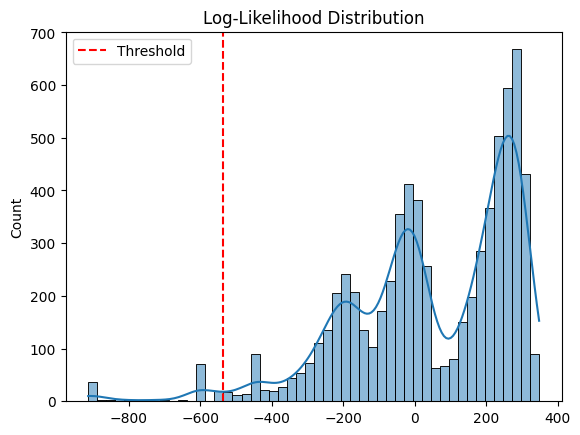

In [217]:
import seaborn as sns

sns.histplot(log_likelihood, bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='dashed', label='Threshold')
plt.legend()
plt.title("Log-Likelihood Distribution")
plt.show()

In [218]:
anomaly_indices = np.where(log_likelihood < threshold)[0]
anomalies = matrix[anomaly_indices]


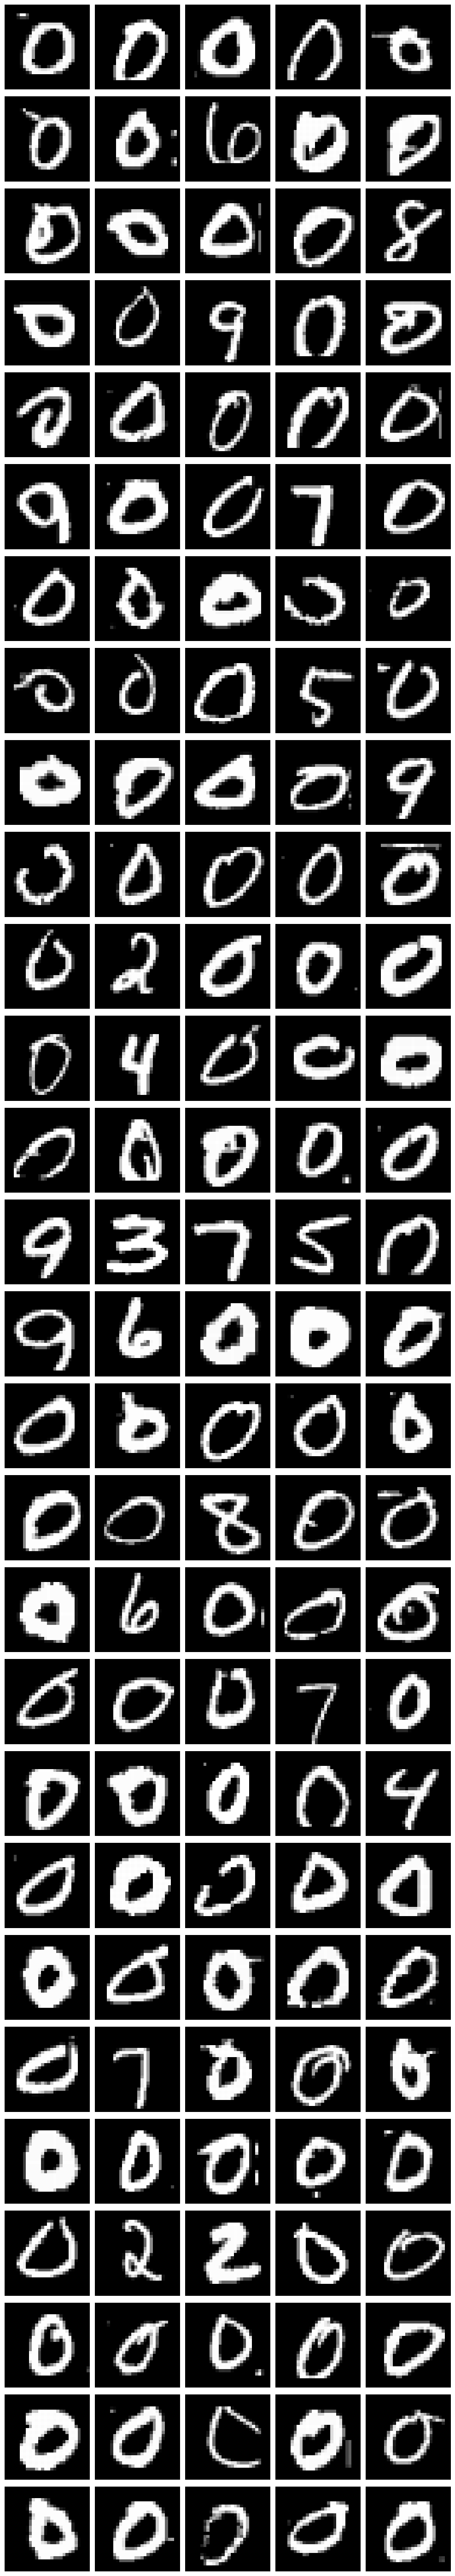

In [219]:
num_anomalies = len(anomaly_indices)
cols = 5
rows = int(np.ceil(num_anomalies / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < num_anomalies:
        axes[i].imshow(anomalies[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [220]:
percentage_of_finded_anomalities(anomaly_indices, anomalies_indices)

28.000000000000004

In [224]:
components = range(2,7)
covariance_types = ["full", "tied", "diag", "spherical"]
initial_params = ["kmeans", "k-means++", "random", "random_from_data"]
best_percent = 0

for c in components:
    for covariance_type in covariance_types:
        for param in initial_params:
            gmm = GaussianMixture(n_components=c, covariance_type=covariance_type, max_iter=300, init_params=param, random_state=42, tol=1e-8)
            gmm.fit(matrix)
            log_likelihood = gmm.score_samples(matrix)
            threshold = np.percentile(log_likelihood, 2)
            anomaly_indices = np.where(log_likelihood < threshold)[0]
            percent = percentage_of_finded_anomalities(anomaly_indices, anomalies_indices)

            if percent > best_percent:
                best_component = c
                best_covariance_type = covariance_type
                best_param=param
                best_model = gmm
                best_percent = percent
            
            print(f"gmm model components : {c}, cov_type : {covariance_type}, init_params : {param}, with score : {percent}\n")

print(f"best gmm model components : {best_component}, cov_type : {best_covariance_type}, init_params : {best_param}, with score : {best_percent}\n")






gmm model components : 2, cov_type : full, init_params : kmeans, with score : 28.000000000000004

gmm model components : 2, cov_type : full, init_params : k-means++, with score : 28.000000000000004

gmm model components : 2, cov_type : full, init_params : random, with score : 20.0

gmm model components : 2, cov_type : full, init_params : random_from_data, with score : 16.0

gmm model components : 2, cov_type : tied, init_params : kmeans, with score : 20.0

gmm model components : 2, cov_type : tied, init_params : k-means++, with score : 20.0



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 2, cov_type : tied, init_params : random, with score : 20.0

gmm model components : 2, cov_type : tied, init_params : random_from_data, with score : 20.0

gmm model components : 2, cov_type : diag, init_params : kmeans, with score : 28.000000000000004

gmm model components : 2, cov_type : diag, init_params : k-means++, with score : 32.0

gmm model components : 2, cov_type : diag, init_params : random, with score : 52.0

gmm model components : 2, cov_type : diag, init_params : random_from_data, with score : 28.000000000000004

gmm model components : 2, cov_type : spherical, init_params : kmeans, with score : 68.0

gmm model components : 2, cov_type : spherical, init_params : k-means++, with score : 68.0

gmm model components : 2, cov_type : spherical, init_params : random, with score : 68.0

gmm model components : 2, cov_type : spherical, init_params : random_from_data, with score : 68.0

gmm model components : 3, cov_type : full, init_params : kmeans, with score 

/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 4, cov_type : tied, init_params : k-means++, with score : 20.0

gmm model components : 4, cov_type : tied, init_params : random, with score : 20.0



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 4, cov_type : tied, init_params : random_from_data, with score : 20.0

gmm model components : 4, cov_type : diag, init_params : kmeans, with score : 40.0

gmm model components : 4, cov_type : diag, init_params : k-means++, with score : 36.0

gmm model components : 4, cov_type : diag, init_params : random, with score : 36.0

gmm model components : 4, cov_type : diag, init_params : random_from_data, with score : 28.000000000000004

gmm model components : 4, cov_type : spherical, init_params : kmeans, with score : 72.0

gmm model components : 4, cov_type : spherical, init_params : k-means++, with score : 72.0

gmm model components : 4, cov_type : spherical, init_params : random, with score : 72.0

gmm model components : 4, cov_type : spherical, init_params : random_from_data, with score : 72.0

gmm model components : 5, cov_type : full, init_params : kmeans, with score : 40.0

gmm model components : 5, cov_type : full, init_params : k-means++, with score : 12.0

gmm

/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 5, cov_type : tied, init_params : kmeans, with score : 20.0

gmm model components : 5, cov_type : tied, init_params : k-means++, with score : 20.0

gmm model components : 5, cov_type : tied, init_params : random, with score : 20.0

gmm model components : 5, cov_type : tied, init_params : random_from_data, with score : 20.0

gmm model components : 5, cov_type : diag, init_params : kmeans, with score : 32.0

gmm model components : 5, cov_type : diag, init_params : k-means++, with score : 28.000000000000004

gmm model components : 5, cov_type : diag, init_params : random, with score : 48.0

gmm model components : 5, cov_type : diag, init_params : random_from_data, with score : 32.0

gmm model components : 5, cov_type : spherical, init_params : kmeans, with score : 76.0

gmm model components : 5, cov_type : spherical, init_params : k-means++, with score : 76.0

gmm model components : 5, cov_type : spherical, init_params : random, with score : 76.0

gmm model componen

/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 6, cov_type : tied, init_params : kmeans, with score : 20.0



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 6, cov_type : tied, init_params : k-means++, with score : 20.0



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 6, cov_type : tied, init_params : random, with score : 20.0



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 6, cov_type : tied, init_params : random_from_data, with score : 20.0

gmm model components : 6, cov_type : diag, init_params : kmeans, with score : 48.0

gmm model components : 6, cov_type : diag, init_params : k-means++, with score : 32.0

gmm model components : 6, cov_type : diag, init_params : random, with score : 32.0

gmm model components : 6, cov_type : diag, init_params : random_from_data, with score : 44.0

gmm model components : 6, cov_type : spherical, init_params : kmeans, with score : 64.0

gmm model components : 6, cov_type : spherical, init_params : k-means++, with score : 64.0

gmm model components : 6, cov_type : spherical, init_params : random, with score : 64.0

gmm model components : 6, cov_type : spherical, init_params : random_from_data, with score : 64.0

best gmm model components : 5, cov_type : spherical, init_params : kmeans, with score : 76.0



In [ ]:
components = range(7,10)
covariance_types = ["spherical"]
initial_params = ["kmeans", "k-means++", "random", "random_from_data"]
best_percent = 0

for c in components:
    for covariance_type in covariance_types:
        for param in initial_params:
            gmm = GaussianMixture(n_components=c, covariance_type=covariance_type, max_iter=300, init_params=param, random_state=42, tol=1e-8)
            gmm.fit(matrix)
            log_likelihood = gmm.score_samples(matrix)
            threshold = np.percentile(log_likelihood, 2)
            anomaly_indices = np.where(log_likelihood < threshold)[0]
            percent = percentage_of_finded_anomalities(anomaly_indices, anomalies_indices)

            if percent > best_percent:
                best_component = c
                best_covariance_type = covariance_type
                best_param=param
                best_model= gmm
                best_percent = percent
            
            print(f"gmm model components : {c}, cov_type : {covariance_type}, init_params : {param}, with score : {percent}\n")

print(f"best gmm model components : {best_component}, cov_type : {best_covariance_type}, init_params : {best_param}, with score : {best_percent}\n")






gmm model components : 7, cov_type : spherical, init_params : kmeans, with score : 64.0

gmm model components : 7, cov_type : spherical, init_params : k-means++, with score : 64.0

gmm model components : 7, cov_type : spherical, init_params : random, with score : 64.0

gmm model components : 7, cov_type : spherical, init_params : random_from_data, with score : 60.0

gmm model components : 8, cov_type : spherical, init_params : kmeans, with score : 68.0

gmm model components : 8, cov_type : spherical, init_params : k-means++, with score : 68.0

gmm model components : 8, cov_type : spherical, init_params : random, with score : 68.0

gmm model components : 8, cov_type : spherical, init_params : random_from_data, with score : 68.0

gmm model components : 9, cov_type : spherical, init_params : kmeans, with score : 76.0

gmm model components : 9, cov_type : spherical, init_params : k-means++, with score : 72.0

gmm model components : 9, cov_type : spherical, init_params : random, with score 

In [226]:
components = range(11, 21)
covariance_types = ["spherical"]
initial_params = ["kmeans", "k-means++", "random", "random_from_data"]
best_percent = 0

for c in components:
    for covariance_type in covariance_types:
        for param in initial_params:
            gmm = GaussianMixture(n_components=c, covariance_type=covariance_type, max_iter=300, init_params=param, random_state=42, tol=1e-8)
            gmm.fit(matrix)
            log_likelihood = gmm.score_samples(matrix)
            threshold = np.percentile(log_likelihood, 2)
            anomaly_indices = np.where(log_likelihood < threshold)[0]
            percent = percentage_of_finded_anomalities(anomaly_indices, anomalies_indices)

            if percent > best_percent:
                best_component = c
                best_covariance_type = covariance_type
                best_param=param
                best_model= gmm
                best_percent = percent
            
            print(f"gmm model components : {c}, cov_type : {covariance_type}, init_params : {param}, with score : {percent}\n")

print(f"best gmm model components : {best_component}, cov_type : {best_covariance_type}, init_params : {best_param}, with score : {best_percent}\n")






gmm model components : 11, cov_type : spherical, init_params : kmeans, with score : 64.0

gmm model components : 11, cov_type : spherical, init_params : k-means++, with score : 64.0

gmm model components : 11, cov_type : spherical, init_params : random, with score : 72.0

gmm model components : 11, cov_type : spherical, init_params : random_from_data, with score : 72.0

gmm model components : 12, cov_type : spherical, init_params : kmeans, with score : 52.0

gmm model components : 12, cov_type : spherical, init_params : k-means++, with score : 52.0

gmm model components : 12, cov_type : spherical, init_params : random, with score : 76.0



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 12, cov_type : spherical, init_params : random_from_data, with score : 80.0

gmm model components : 13, cov_type : spherical, init_params : kmeans, with score : 72.0



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 13, cov_type : spherical, init_params : k-means++, with score : 52.0

gmm model components : 13, cov_type : spherical, init_params : random, with score : 36.0



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 13, cov_type : spherical, init_params : random_from_data, with score : 76.0

gmm model components : 14, cov_type : spherical, init_params : kmeans, with score : 60.0

gmm model components : 14, cov_type : spherical, init_params : k-means++, with score : 60.0



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 14, cov_type : spherical, init_params : random, with score : 56.00000000000001

gmm model components : 14, cov_type : spherical, init_params : random_from_data, with score : 76.0



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 15, cov_type : spherical, init_params : kmeans, with score : 56.00000000000001

gmm model components : 15, cov_type : spherical, init_params : k-means++, with score : 60.0

gmm model components : 15, cov_type : spherical, init_params : random, with score : 28.000000000000004



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 15, cov_type : spherical, init_params : random_from_data, with score : 48.0

gmm model components : 16, cov_type : spherical, init_params : kmeans, with score : 56.00000000000001

gmm model components : 16, cov_type : spherical, init_params : k-means++, with score : 56.00000000000001

gmm model components : 16, cov_type : spherical, init_params : random, with score : 52.0



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 16, cov_type : spherical, init_params : random_from_data, with score : 28.000000000000004

gmm model components : 17, cov_type : spherical, init_params : kmeans, with score : 60.0

gmm model components : 17, cov_type : spherical, init_params : k-means++, with score : 56.00000000000001

gmm model components : 17, cov_type : spherical, init_params : random, with score : 52.0

gmm model components : 17, cov_type : spherical, init_params : random_from_data, with score : 40.0



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 18, cov_type : spherical, init_params : kmeans, with score : 56.00000000000001

gmm model components : 18, cov_type : spherical, init_params : k-means++, with score : 56.00000000000001



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 18, cov_type : spherical, init_params : random, with score : 28.000000000000004

gmm model components : 18, cov_type : spherical, init_params : random_from_data, with score : 44.0

gmm model components : 19, cov_type : spherical, init_params : kmeans, with score : 60.0

gmm model components : 19, cov_type : spherical, init_params : k-means++, with score : 56.00000000000001

gmm model components : 19, cov_type : spherical, init_params : random, with score : 60.0

gmm model components : 19, cov_type : spherical, init_params : random_from_data, with score : 28.000000000000004

gmm model components : 20, cov_type : spherical, init_params : kmeans, with score : 56.00000000000001

gmm model components : 20, cov_type : spherical, init_params : k-means++, with score : 56.00000000000001



/home/parsamhb82/projects/my_envs/ml3/lib/python3.12/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


gmm model components : 20, cov_type : spherical, init_params : random, with score : 72.0

gmm model components : 20, cov_type : spherical, init_params : random_from_data, with score : 28.000000000000004

best gmm model components : 12, cov_type : spherical, init_params : random_from_data, with score : 80.0



In [228]:
components = range(12, 13)
covariance_types = ["spherical"]
initial_params = ["kmeans", "k-means++", "random", "random_from_data"]
best_percent = 0

for c in components:
    for covariance_type in covariance_types:
        for param in initial_params:
            gmm = GaussianMixture(n_components=c, covariance_type=covariance_type, max_iter=1000, init_params=param, random_state=42, tol=1e-8)
            gmm.fit(matrix)
            log_likelihood = gmm.score_samples(matrix)
            threshold = np.percentile(log_likelihood, 2)
            anomaly_indices = np.where(log_likelihood < threshold)[0]
            percent = percentage_of_finded_anomalities(anomaly_indices, anomalies_indices)

            if percent > best_percent:
                best_component = c
                best_covariance_type = covariance_type
                best_param=param
                best_model= gmm
                best_percent = percent
            
            print(f"gmm model components : {c}, cov_type : {covariance_type}, init_params : {param}, with score : {percent}\n")

print(f"best gmm model components : {best_component}, cov_type : {best_covariance_type}, init_params : {best_param}, with score : {best_percent}\n")






gmm model components : 12, cov_type : spherical, init_params : kmeans, with score : 52.0

gmm model components : 12, cov_type : spherical, init_params : k-means++, with score : 52.0

gmm model components : 12, cov_type : spherical, init_params : random, with score : 76.0

gmm model components : 12, cov_type : spherical, init_params : random_from_data, with score : 80.0

best gmm model components : 12, cov_type : spherical, init_params : random_from_data, with score : 80.0



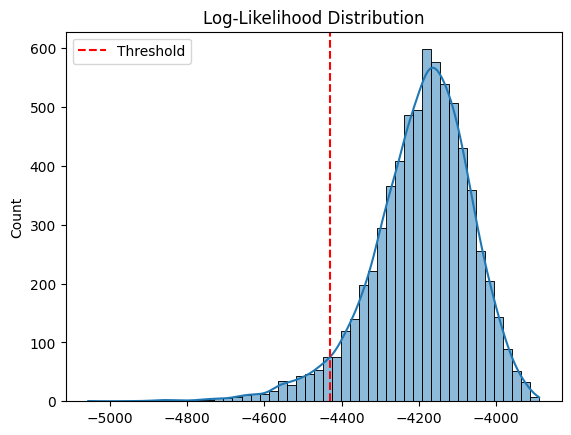

In [248]:
log_likelihood = best_model.score_samples(matrix)
threshold = np.percentile(log_likelihood, 5)

import seaborn as sns

sns.histplot(log_likelihood, bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='dashed', label='Threshold')
plt.legend()
plt.title("Log-Likelihood Distribution")
plt.show()


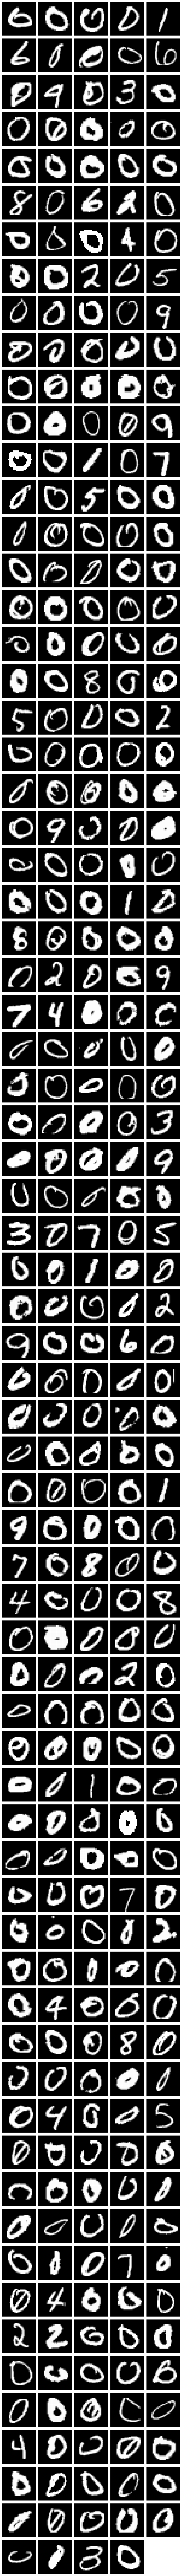

92.0


In [249]:
anomaly_indices = np.where(log_likelihood < threshold)[0]
anomalies = matrix[anomaly_indices]
num_anomalies = len(anomaly_indices)
cols = 5
rows = int(np.ceil(num_anomalies / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < num_anomalies:
        axes[i].imshow(anomalies[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()
print(percentage_of_finded_anomalities(anomaly_indices, anomalies_indices))

In [250]:
gmm_5 = GaussianMixture(n_components=5, covariance_type="spherical", max_iter=1000, init_params="kmeans", random_state=42, tol=1e-8)
gmm_5.fit(matrix)
log_likelihood = gmm_5.score_samples(matrix)
threshold = np.percentile(log_likelihood, 2)
anomaly_indices = np.where(log_likelihood < threshold)[0]
percent = percentage_of_finded_anomalities(anomaly_indices, anomalies_indices)

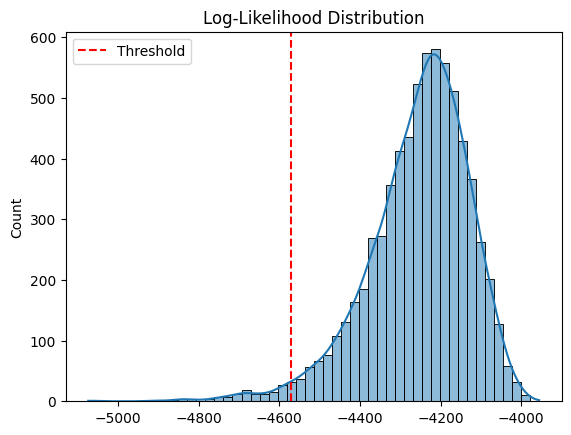

In [261]:
log_likelihood = gmm_5.score_samples(matrix)
threshold = np.percentile(log_likelihood, 2)

import seaborn as sns

sns.histplot(log_likelihood, bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='dashed', label='Threshold')
plt.legend()
plt.title("Log-Likelihood Distribution")
plt.show()


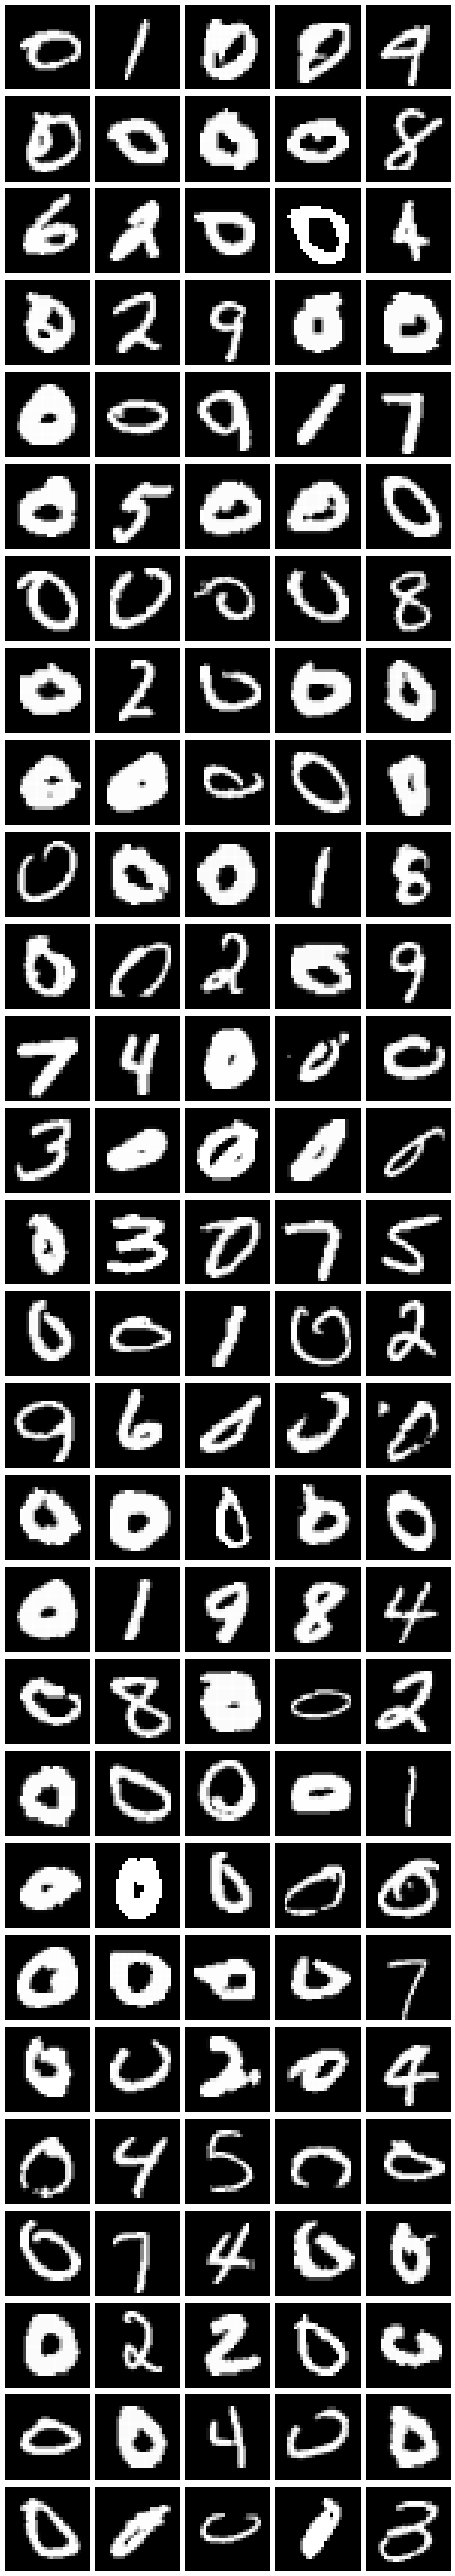

76.0


In [262]:
anomaly_indices = np.where(log_likelihood < threshold)[0]
anomalies = matrix[anomaly_indices]
num_anomalies = len(anomaly_indices)
cols = 5
rows = int(np.ceil(num_anomalies / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < num_anomalies:
        axes[i].imshow(anomalies[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()
print(percentage_of_finded_anomalities(anomaly_indices, anomalies_indices))

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

input_dim = 784
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dropout(0.2)(encoded)  
encoded = Dense(32, activation='relu')(encoded)

# Decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# Autoencoder Model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

2025-02-26 23:46:51.050791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740601011.206209    4698 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740601011.242283    4698 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 23:46:51.538487: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1740601015.312143    4698 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

In [28]:
ae_matrix = matrix / 255.0
autoencoder.fit(ae_matrix, ae_matrix, epochs=100, batch_size=256, shuffle=True, validation_split=0.1)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1479 - val_loss: 0.0876
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0554 - val_loss: 0.0596
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0417 - val_loss: 0.0451
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0373 - val_loss: 0.0400
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0350 - val_loss: 0.0358
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0332 - val_loss: 0.0332
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0317 - val_loss: 0.0308
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0304 - val_loss: 0.0293
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0293 - val_loss: 0.0280
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0283 - val_loss: 0.0265
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0276 - val_loss: 0.0256
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss:

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


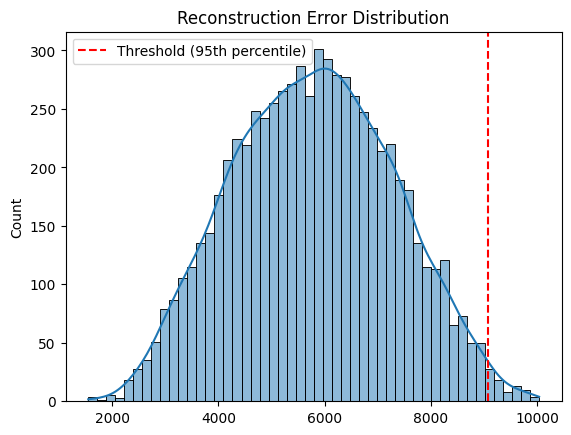

In [ ]:
reconstructed = autoencoder.predict(matrix)

reconstruction_error = np.mean((matrix - reconstructed) ** 2, axis=1)

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(reconstruction_error, bins=50, kde=True)
plt.axvline(np.percentile(reconstruction_error, 99), color='red', linestyle='dashed', label='Threshold (95th percentile)')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()


In [ ]:
threshold = np.percentile(reconstruction_error, 99)

anomaly_indices = np.where(reconstruction_error > threshold)[0]

anomalies = matrix[anomaly_indices]

print(f"Detected {len(anomalies)} anomalies out of {len(matrix)} samples")


Detected 70 anomalies out of 6963 samples


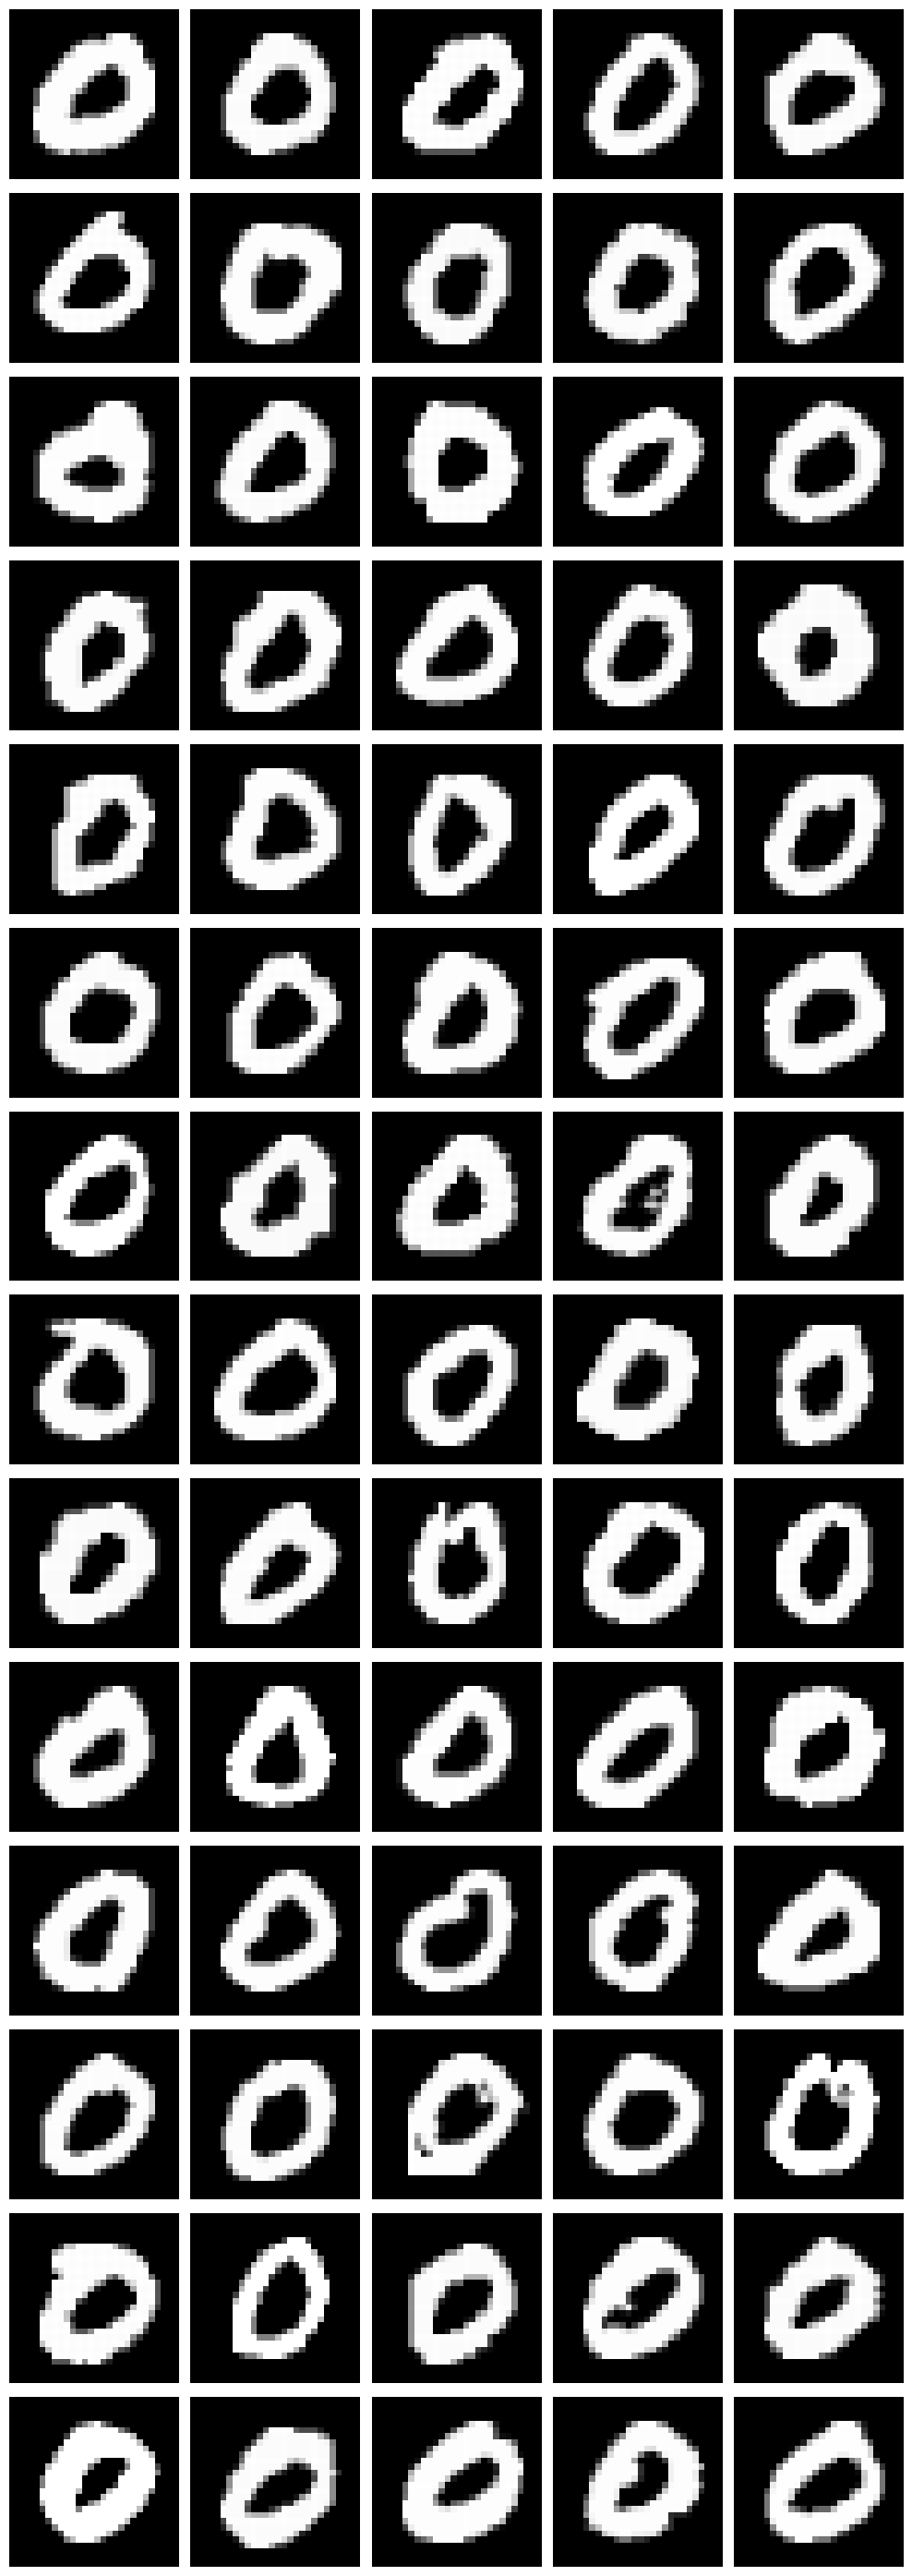

In [31]:
num_anomalies = len(anomalies)
cols = 5
rows = int(np.ceil(num_anomalies / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):  
    if i < num_anomalies:
        axes[i].imshow(anomalies[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [285]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from tensorflow.keras.models import Model

input_dim = (28, 28, 1)
input_layer = Input(shape=input_dim)

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  
# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Cropping2D(((2, 2), (2, 2)))(x)  

decoded = Conv2D(1, (3, 3), activation="linear", padding='same')(x) 
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

cnn_matrix = matrix.reshape(-1, 28, 28, 1) / 255.0
autoencoder.fit(cnn_matrix, cnn_matrix, epochs=100, batch_size=256, shuffle=True, validation_split=0.1)







Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 443ms/step - loss: 0.1242 - val_loss: 0.0801
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step - loss: 0.0682 - val_loss: 0.0477
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 448ms/step - loss: 0.0438 - val_loss: 0.0352
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 420ms/step - loss: 0.0329 - val_loss: 0.0267
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step - loss: 0.0251 - val_loss: 0.0212
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 449ms/step - loss: 0.0204 - val_loss: 0.0184
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 444ms/step - loss: 0.0195 - val_loss: 0.0173
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - loss: 0.0165 - val_loss: 0.0155
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 475ms/step - loss: 0.0150 - val_loss: 0.0149
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 468ms/step - loss: 0.0143 - val_loss: 0.0137
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 472ms/step - loss: 0.0139 - val_loss: 0.0136
Epoch 12/100
25/25 ━━━━━━━━━━━

218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


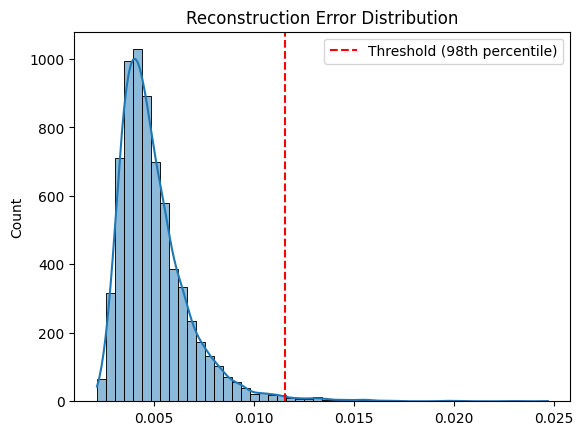

In [286]:
reconstructed = autoencoder.predict(cnn_matrix)

reconstruction_error = np.mean((cnn_matrix - reconstructed) ** 2, axis=(1, 2, 3))

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(reconstruction_error, bins=50, kde=True)
plt.axvline(np.percentile(reconstruction_error, 99), color='red', linestyle='dashed', label='Threshold (98th percentile)')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()

Detected 202 anomalies out of 6963 samples
score percentage 56.00000000000001


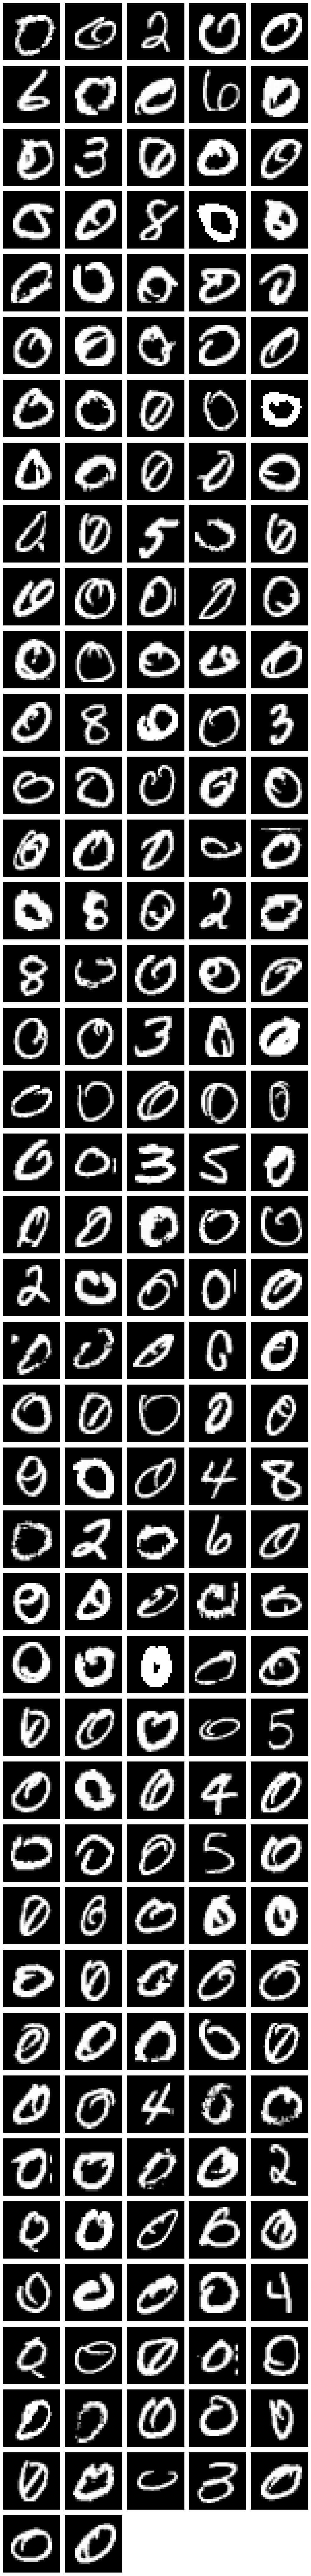

In [289]:
threshold = np.percentile(reconstruction_error, 97.1)
anomaly_indices = np.where(reconstruction_error > threshold)[0]
anomalies = cnn_matrix[anomaly_indices]

print(f"Detected {len(anomalies)} anomalies out of {len(cnn_matrix)} samples")
print("score percentage",percentage_of_finded_anomalities(anomaly_indices, anomalies_indices))
num_anomalies = len(anomalies)
cols = 5
rows = int(np.ceil(num_anomalies / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < num_anomalies:
        axes[i].imshow(anomalies[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [290]:
print(percentage_of_finded_anomalities(anomaly_indices, anomalies_indices))

56.00000000000001


In [304]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from tensorflow.keras.models import Model

input_dim = (28, 28, 1)
input_layer = Input(shape=input_dim)

# Encoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Cropping2D(((2, 2), (2, 2)))(x)  

decoded = Conv2D(1, (3, 3), activation="linear", padding='same')(x) 
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

cnn_matrix = matrix.reshape(-1, 28, 28, 1) / 255.0
autoencoder.fit(cnn_matrix, cnn_matrix, epochs=10, batch_size=8, shuffle=True, validation_split=0.1)

Epoch 1/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0546 - val_loss: 0.0201
Epoch 2/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0182 - val_loss: 0.0162
Epoch 3/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0150 - val_loss: 0.0137
Epoch 4/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 5/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0126 - val_loss: 0.0122
Epoch 6/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0117 - val_loss: 0.0116
Epoch 7/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 8/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0109 - val_loss: 0.0118
Epoch 9/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 10/10
784/784 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0101 - val_loss: 0.0112


In [315]:
reconstructed = autoencoder.predict(cnn_matrix)

reconstruction_error = np.mean((cnn_matrix - reconstructed) ** 2, axis=(1, 2, 3))

threshold = np.percentile(reconstruction_error, 97.1)
anomaly_indices = np.where(reconstruction_error > threshold)[0]
anomalies = cnn_matrix[anomaly_indices]
print(f"Detected {len(anomalies)} anomalies out of {len(cnn_matrix)} samples")
print("score percentage",percentage_of_finded_anomalities(anomaly_indices, anomalies_indices))




218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Detected 202 anomalies out of 6963 samples
score percentage 92.0


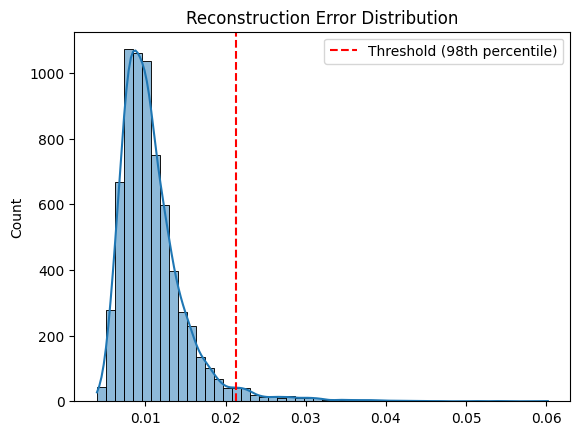

In [316]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(reconstruction_error, bins=50, kde=True)
plt.axvline(np.percentile(reconstruction_error, 97.1), color='red', linestyle='dashed', label='Threshold (98th percentile)')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()

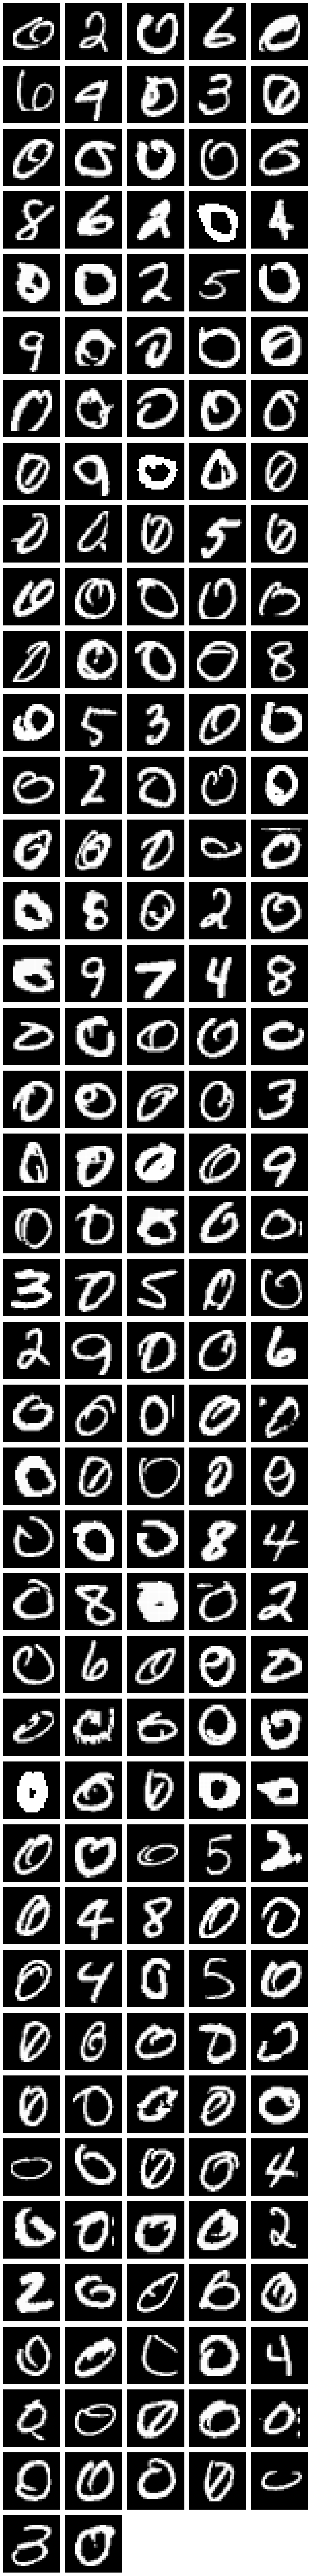

In [317]:
num_anomalies = len(anomalies)
cols = 5
rows = int(np.ceil(num_anomalies / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < num_anomalies:
        axes[i].imshow(anomalies[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()